# Maximin Affinity Learning of Image Segmentation (MALIS)

In this notebook, we will implement the following paper:

> [ *Large Scale Image Segmentation with Structured Loss Based Deep Learning for Connectome Reconstruction*, J. Funke et al., IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 41, pp. 1669–1680, July 2019.](https://ieeexplore.ieee.org/document/8364622)
    
We tried to be as faithful as possible to the method presented in the paper, especially regarding the loss function.

In [1]:
!nvidia-smi

Tue Jul 14 15:16:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
!pip install higra

#tools
import numpy as np
import matplotlib.pyplot as plt
import h5py
import skimage.measure
import time
from IPython.display import clear_output
import higra as hg

#torch
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Projet_E4/3d\ unet

In [ ]:
from IPython.display import clear_output

def print_state(net, input_im, Lp, Ln,tot,samples=50, slice_idx=50):
  #plot preditctions
  fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(22,7))
  Ln_sampled = []
  Lp_sampled = []
  tot_sampled = []
  xs = []
  for i in range(len(Lp) // samples):
      Ln_sampled.append(np.mean(Ln[i*samples:(i+1)*samples]))
      Lp_sampled.append(np.mean(Lp[i*samples:(i+1)*samples]))
      tot_sampled.append(np.mean(tot[i*samples:(i+1)*samples]))
      xs.append(i*samples + samples/2)

  lp, = ax1.plot(xs,Lp_sampled, label="Positive Loss",color="g")

  ax1p = ax1.twinx()

  ln, = ax1p.plot(xs,Ln_sampled, label="Negative Loss") 
  #sol, = ax1p.plot(xs,tot_sampled, label="Sum of losses") 
  #plt.legend(handles=[ln,lp,sol])
  plt.legend(handles=[ln,lp])

  plt.ylim(bottom=0)
  plt.xlim(left=0)
  plt.ylabel("Loss value")
  plt.xlabel("Iteration")
  plt.title("Losses")
  #plt.axvline(x=34200)
  
  
  #Make preds
  input_im = torch.stack([input_im])
  input_im = torch.stack([input_im])
  
  input_im = input_im.to(device,dtype=torch.float)
  pred = net(input_im).detach().cpu().numpy()

  pred_x = pred[0][0][slice_idx]
  pred_y = pred[0][1][slice_idx]
  pred_z = pred[0][2][slice_idx]

  #ax2.imshow(pred_x,cmap="gray", vmin=0, vmax=1)
  ax2.imshow(pred_x,cmap="gray")
  ax2.axis('off')
  ax2.set_title("Predictions on the x axis")

  #ax3.imshow(pred_y,cmap="gray", vmin=0, vmax=1)
  ax3.imshow(pred_y,cmap="gray")
  ax3.axis('off')
  ax3.set_title("Predictions on the y axis")

  #ax4.imshow(pred_z,cmap="gray", vmin=0, vmax=1)
  ax4.imshow(pred_z,cmap="gray")
  ax4.axis('off')
  ax4.set_title("Predictions on the z axis")
  
  fig.tight_layout()
  clear_output(wait=True)
  plt.show()
  del input_im
  del pred
  del pred_x
  del pred_y
  del pred_z

# U-net architecture

In [ ]:
from unet_3d import UNet

net = UNet().to(device)
summary(net, (1,84,268,268))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 12, 82, 266, 266]             336
            Conv3d-2     [-1, 12, 80, 264, 264]           3,900
         MaxPool3d-3       [-1, 12, 80, 88, 88]               0
            Conv3d-4       [-1, 60, 78, 86, 86]          19,500
            Conv3d-5       [-1, 60, 76, 84, 84]          97,260
         MaxPool3d-6       [-1, 60, 76, 28, 28]               0
            Conv3d-7      [-1, 300, 74, 26, 26]         486,300
            Conv3d-8      [-1, 300, 72, 24, 24]       2,430,300
         MaxPool3d-9        [-1, 300, 72, 8, 8]               0
           Conv3d-10       [-1, 1500, 70, 6, 6]      12,151,500
           Conv3d-11       [-1, 1500, 68, 4, 4]      60,751,500
  ConvTranspose3d-12      [-1, 300, 68, 12, 12]       4,050,300
           Conv3d-13      [-1, 300, 68, 12, 12]         180,300
           Conv3d-14      [-1, 300, 66,

# Hyperparameters

In [ ]:
EXP_NAME = "3D_final"

EPOCHS = 1000
BATCH_SIZE = 1 
LEARNING_RATE = 1e-4
BETA_1 = 0.95
BETA_2 = 0.99

N_IT = 50 

INPUT_SIZE = (84,268,268)
OUTPUT_SIZE = tuple(net(torch.zeros((1,1) + INPUT_SIZE).to(device)).shape[2:])
DELTA = tuple(map(lambda x, y: (x - y)//2, INPUT_SIZE, OUTPUT_SIZE))
STRIDE = (42,134,134)

# Dataset
In this example, we use the [CREMI](https://cremi.org/data/) dataset, and will load directly the hdf file into a PyTorch dataset. 

This function will be used to obtain all MxNxN patches in an image. (84x268x268 in our case)

The parameter stride will be used to get overlapping images. A stride of S will give us an overlap of N-S between our patches


In [ ]:
def get_patches(volume, segmentation, patch_size, stride):
    patches = []
    for i in range(0, volume.shape[0]-patch_size[0], stride[0]):
        for j in range(0, volume.shape[1]-patch_size[1], stride[1]):
            for k in range(0, volume.shape[2]-patch_size[2], stride[2]):
                patches.append( (torch.tensor(volume[i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]], device=device, dtype=torch.float32),
                                 torch.tensor(segmentation[i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]].astype(np.int32), dtype=torch.int32)) )
    return patches

In [ ]:
class CREMIDataset(Dataset):

    def __init__(self, dataset_path, transform=None):
        hdf_file = h5py.File(dataset_path, 'r')
        self.patches = get_patches(volume = hdf_file['volumes/raw'], 
                                   segmentation = hdf_file['volumes/labels/neuron_ids'], 
                                   patch_size = INPUT_SIZE, 
                                   stride = STRIDE)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        volume, segmentation = self.patches[idx]
        volume = torch.unsqueeze(volume, dim=0)
        segmentation = torch.unsqueeze(segmentation, dim=0)

        sample = {'volume': (volume/255)*2 - 1, 'segmentation': segmentation}
        return sample

In [ ]:
DATASET_PATH = '../CREMI datasets/train.hdf'

In [ ]:
dataset = CREMIDataset(DATASET_PATH)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True)

# Graph Functions


## Graph weights

This function is used to get the graph weights corresponding to our NN output.



In [ ]:
def get_weights(x,y,z):
  depth, heigh, width = x.shape

  #In a first time we compute "simple" edge weights
  z_u = z[:-1,:-1,:-1].permute(0,2,1)
  y_u = y[:-1,1:,:-1].permute(0,2,1)
  x_u = x[:-1,:-1,:-1].permute(0,2,1)

  out = torch.empty((depth-1,3*(width-1), heigh-1), device=device)
  out[:,0::3,:] = x_u
  out[:,1::3,:] = y_u
  out[:,2::3,:] = z_u

  y_x = y[:-1,1:,-1]
  z_x = z[:-1,:-1,-1]
  #Concatenate weights from the face in the direction x
  out = torch.cat((out, torch.stack((y_x, z_x),1) ), 1)

  #Flatten following dimension 1 before concat with border weights
  out = torch.flatten(out.transpose(1, 2), start_dim=1)

  #Create border weights (x,z) in direction y
  border = torch.empty((depth-1,2*width-1), device=device)
  border[:,:-1:2]=x[:-1,-1,:-1]
  border[:,1::2]=z[:-1,-1,:-1]
  border[:,-1]=z[:-1,-1,-1]

  out = torch.cat((out, border), 1).flatten()

  #Create border weights (x,y) in direction z
  border_1 = torch.empty((heigh-1,2*width-1), device=device)
  border_1[:,1::2]=y[-1,1:,:-1]
  border_1[:,0:-1:2]=x[-1,:-1,:-1]
  border_1[:,-1]=y[-1,1:,-1]
  border_1=torch.cat((border_1.flatten(), x[-1,-1,:-1]))
  border_1

  out = torch.cat((out, border_1), 0)
  return out

## Get mask from groundtruth

In [ ]:
def get_mask(g,vertex_classes):
  weights = hg.weight_graph(g,vertex_classes.flatten(),hg.WeightFunction.L1)
  weights[weights != 0 ] = 1
  return weights

## Maximin

To calculate the maximin edge value for all pairs of pixels, we will use a binary partition tree as described in [Playing with Kruskal: algorithms for morphological trees in edge-weighted graphs](https://hal.archives-ouvertes.fr/hal-00798621/). This will give us all the necessary data needed to compute the loss.

In [ ]:
def relabel(tab):
    #coef = 1/tab.min().type(torch.FloatTensor)
    #tab= (tab*coef).type(torch.IntTensor)
    labeled = skimage.measure.label(tab, background=0, connectivity=1)
    return labeled-1, np.unique(labeled).shape[0]


Here we will use cython for a small bit of code, as it was a major bottleneck during training

In [ ]:
%load_ext cython

In [ ]:
%%cython
import numpy as np
cimport numpy as np
from cython import wraparound, boundscheck

DTYPE = np.int
ctypedef np.int_t DTYPE_t

#def compute_areas(vertex_labels, left, right, V, k):
@boundscheck(False) # turn off bounds-checking for entire function
def compute_areas(np.ndarray[DTYPE_t, ndim=1] vertex_labels, np.ndarray[DTYPE_t, ndim=1] left, np.ndarray[DTYPE_t, ndim=1] right,DTYPE_t V,DTYPE_t k):
    cdef np.ndarray[DTYPE_t, ndim=2] T = np.zeros((2*V-1,k),dtype=DTYPE)
    cdef int i,j,l,r
    for i in range(0,V):
        T[i,vertex_labels[i]] = 1
    for i in range(V-1):
        for j in range(k):
            T[V+i,j] = T[left[i],j] + T[right[i],j]
    return T

In [ ]:
def get_maximin_edges(graph, edge_weights, truth, step):
    V = graph.num_vertices()

    #Relabel our groundtruth for ease of computation
    labeled,k = relabel(truth)
    vertex_weights = labeled.flatten()

    tree, altitudes = hg.bpt_canonical(graph, -edge_weights.detach().numpy())
    mst = hg.get_attribute(tree,"mst")
    mst_map =hg.get_attribute(mst,"mst_edge_map")
   
    #areas 0:|V| = nodes, areas |V|:2|V|-2 = edges
    #CF playing with kruskal
    areas = hg.attribute_area(tree)
    right = tree.child(1)
    left = tree.child(0)

    #Computing the areas of each label k
    T = compute_areas(vertex_weights, left, right, V, k)
     
    for i in range(left.size):
      T[V+i,:] = T[left[i],:] + T[right[i],:]

    wp = np.sum(T[left,:]*T[right,:],axis=1)
    if step == "positive":
      return wp, mst_map
    else:
      wn = areas[right]*areas[left] - wp
      return wn, mst_map

# Loss and optimizer

In [ ]:
def l(truth, predicted):
    return (truth-predicted)**2

In [ ]:
def positive_loss(wp,affinities,f):
    Lp = torch.from_numpy(wp).to(device)*f(torch.ones(affinities.shape,device=device),affinities)
    return Lp
def negative_loss(wn,affinities,f):
    Ln = torch.from_numpy(wn).to(device)*f(torch.zeros(affinities.shape,device=device),affinities)
    return Ln

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2))

# Training

In [ ]:
losses=[]
losses_p=[]
losses_n=[]
it = 0

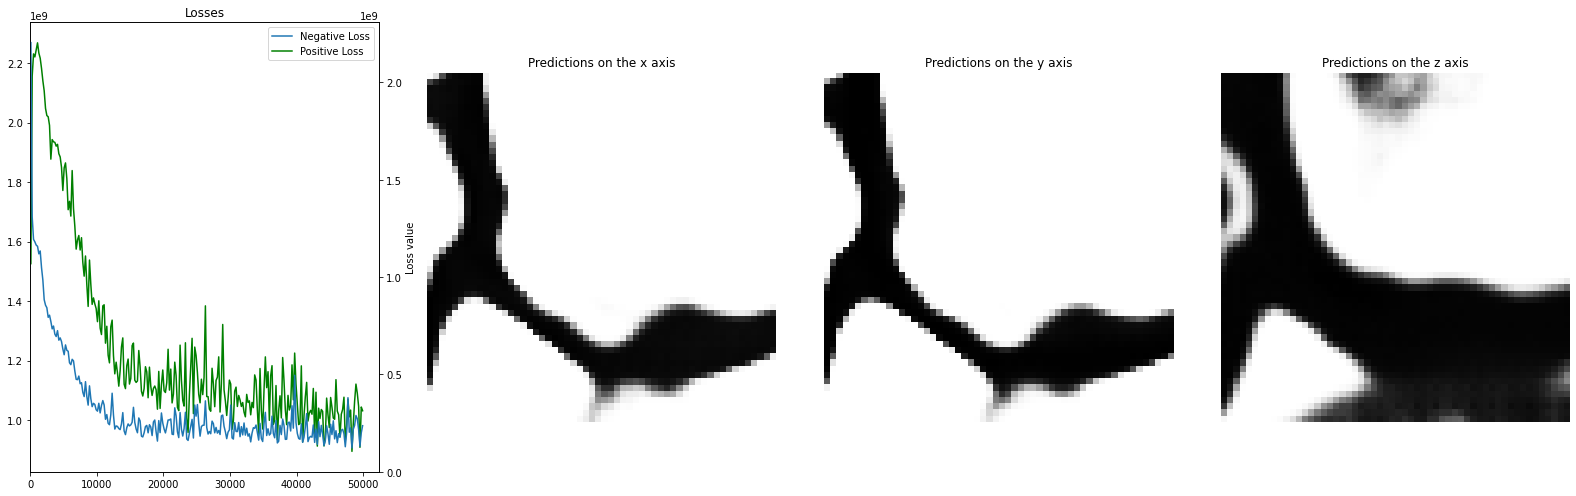

50150 th iteration, avg Lp:  953095200.0  Ln:  166709310.56299987 time taken:  125.35989117622375 seconds


In [ ]:
def train():
    global it
    mask = [[[0, 0, 0], [0, 1, 0], [0, 0, 0]],
            [[0, 1, 0], [1, 0, 1], [0, 1, 0]],
            [[0, 0, 0], [0, 1, 0], [0, 0, 0]]]
    neighbours = hg.mask_2_neighbours(mask)
    graph = hg.get_nd_regular_graph(OUTPUT_SIZE, neighbours)
    start=time.time()
    for epoch in range(EPOCHS):
        #For each volume in the dataset
        for i, patch in enumerate(dataloader):
            net.zero_grad()

            volume = patch['volume']
            segmentation = patch['segmentation']
            # crop our groundtruth
            segmentation = segmentation[0, 0, DELTA[0]:-DELTA[0], DELTA[1]:-DELTA[1], DELTA[2]:-DELTA[2]]

            # Making predictioms
            output = net(volume)
            output_x = output[0, 0, :,:,:]
            output_y = output[0, 1, :,:,:]
            output_z = output[0, 2, :,:,:]
        
            # Retrieving the maximin edge using Higra   
            edge_weights = get_weights(output_x, output_y, output_z)
            
            # mask[i] = 0 => Edge is between same object 
            #         = 1 => Edge is between different object
            mask = get_mask(graph, segmentation)
            #=================================
            #        positive pass  
            #=================================
            
            positive_edges = edge_weights.clone().detach()
            # negative edges to 0
            positive_edges[mask==1] = 0 
            # get maximin edges
            wp, mst_map = get_maximin_edges(graph, positive_edges.to("cpu"), segmentation, step="positive")
            mm_positive_values = edge_weights[mst_map]
            Lp = positive_loss(wp, mm_positive_values, l)

            negative_edges = edge_weights.clone().detach()
            # positive edges to 1
            negative_edges[mask==0] = 1
            # get maximin edges
            wn, mst_map = get_maximin_edges(graph, negative_edges.to("cpu"), segmentation, step="negative")
            mm_negative_values = edge_weights[mst_map]
            Ln = negative_loss(wn, mm_negative_values, l)

            #=================================
            #        Sum of losses 
            #=================================

            loss = torch.sum(Lp + Ln)

            losses.append(loss.clone().detach().cpu().numpy())
            losses_p.append(torch.sum(Lp).clone().detach().cpu().numpy())
            losses_n.append(torch.sum(Ln).clone().detach().cpu().numpy())

            # Updating weights
            loss.backward()
            optimizer.step()
            it += 1
            
            if it%50 == 0:
                print_state(net, dataset[0]["volume"][0].clone().detach().cpu(), losses_p, losses_n, losses,samples=200)
                print(it,"th iteration, avg Lp: ", np.mean(losses_p[it-200:it-1])," Ln: ",np.mean(losses_n[it-200:it-1]),  "time taken: ",time.time()-start,"seconds" )
                start= time.time()

            if it%1000 == 0:
                filename = './checkpoints/'+EXP_NAME+'_'+str(it)+'.ckpt'
                torch.save({
                  'iteration': it,
                  'model_state_dict': net.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss_p': losses_p,
                  'loss_n': losses_n
                  }, filename)
                
            if it == N_IT:
              torch.save(net.state_dict(), "./models/model_"+EXP_NAME+".pt" )
              np.save("./losses/p_loss_"+EXP_NAME+".npy", np.array(losses_p))
              np.save("./losses/n_loss_"+EXP_NAME+".npy", np.array(losses_n))
              return
          
            del output
            del output_x
            del output_y
            del edge_weights
train()

In [ ]:
torch.save(net.state_dict(), "./models/model_"+EXP_NAME+".pt" )
np.save("./losses/p_loss_"+EXP_NAME+".npy", np.array(losses_p))
np.save("./losses/n_loss_"+EXP_NAME+".npy", np.array(losses_n))